<h1 style="font-size:40px;"><center>Exercise III:<br> Image Segmentation using CNNs
</center></h1>

## Short summary
In this exercise, we will design a CNN-based **encoder-decoder architecture** to segment rgb images. Image segmentation refers to dividing the image into semantically meaningful regions. For instance, representing each object in the scene with a unique color. The current folder has **three files**: 
- **configSegmenter.py:** this involves definitions of all parameters and data paths
- **utilsSegmenter.py:** includes utility functions required to grab and visualize data 
- **runSegmenter.ipynb:** contains the script to design, train and test the network 

Make sure that before running this script, you created an environment and **installed all required libraries** such 
as keras. The very same environment used in Exercise II can be used here as well.

## The data
There exists also a subfolder called **data** which contains the traning, validation, and testing data each has both RGB input images together with the corresponding ground truth segmentation images.


## The exercises
As for the previous lab all exercises are found below.


## The different 'Cells'
This notebook contains several cells with python code, together with the markdown cells (like this one) with only text. Each of the cells with python code has a "header" markdown cell with information about the code. The table below provides a short overview of the code cells. 

| #  |  CellName | CellType | Comment |
| :--- | :-------- | :-------- | :------- |
| 1 | Init | Needed | Sets up the environment|
| 2 | Ex | Exercise 1| A class definition of a CNN model  |
| 3 | Loading | Needed | Loading parameters and initializing the model |
| 4 | Stats | Needed | Show data distribution |
| 5 | Data | Needed | Data augementation |
| 6 | Data | Needed | Generating the data batches |
| 7 | Debug | Needed | Debugging the data |
| 8 | Device | Needed | Selecting CPU/GPU |
| 9 | Optimization | Exercise 2 | Selecting an optimization method |
| 10 | Training | Exercise 2 | Training the model   |
| 11 | Testing | Exercise 2| Testing the  method   | 
| 13 | Plotting | Information  | View some of test samples |
| 13 | Saving | Information  | Saving the model|


In order for you to start with the exercise you need to run all cells. It is important that you do this in the correct order, starting from the top and work you way down the cells. Later when you have started to work with the notebook it may be easier to use the command "Run All" found in the "Cell" dropdown menu.

## Writing the report
First the report should be written within this notebook. We have prepared the last cell in this notebook for you where you should write the report. The report should contain 4 parts:

* Name:
* Introduction: A **few** sentences where you give a small introduction of what you have done in the lab.
* Answers to questions: For each of the questions provide an answer. It can be short answers or a longer ones depending on the nature of the questions, but try to be effective in your writing.
* Conclusion: Summarize your findings in a few sentences.
  

1) We first start with importing all required modules

In [681]:
#%reset

In [2]:
%load_ext autoreload

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession


##etting GPUS before importing tensorflow to make sure it loads on the right one
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import os

import tensorflow as tf
from tensorflow import keras
from utilsSegmenter import *
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime
import os
import pprint


# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, Conv1D, Convolution2D, Deconvolution2D, Cropping2D, UpSampling2D
from keras.layers import Input,  Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers import Concatenate, concatenate, Reshape
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.layers import Input, merge
from keras.regularizers import l2
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, Add

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from configSegmenter import flying_objects_config
%autoreload

cfg = flying_objects_config()

In [5]:
flying_objects_config()

{'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation',
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'fineGrained': False,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'NUM_CLASS': 4,
 'GPU': 0,
 'DROPOUT_PROB': 0.2,
 'IMAGE_WIDTH': 128,
 'IMAGE_HEIGHT': 128,
 'IMAGE_CHANNEL': 3,
 'NUM_EPOCHS': 5,
 'BATCH_SIZE': 32,
 'LEARNING_RATE': 0.001,
 'LR_DECAY_FACTOR': 0.1,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'DEBUG_MODE': True,
 'DATA_AUGMENTATION': True}

In [6]:
%autoreload

In [7]:
cfg.NUM_EPOCHS = 10
opt = tf.optimizers.Adam(lr=1E-5, beta_1=0.9, beta_2=0.999,epsilon=1e-08)

2) Here, we have the network model class definition. In this class, the most important function is the one called **create_model()**. As defined in the exercises section, your task is to update the network architecture defined in this function such that the network will return the highest accuracy for the given training, validation, and testing data.

In [14]:
testRun = datetime.now()
class SegmenterDNNModel():
    def __init__(self, num_classes=10, batch_size=32, inputShape=(64,64,3), dropout_prob=0.25):
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.inputShape = inputShape
        self.dropout_prob = dropout_prob

    def conv2d_block(self, input_tensor, n_filters, kernel_size=3, batchnorm=True, dropout=True):
        # first layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", kernel_regularizer='l2',
                   padding="same")(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        if dropout:
            x = Dropout(0.2)(x)
        x = Activation("relu")(x)
        return x
    def upsample(self, input_tensor, n_filters, kernel_size=3, batchnorm=True, dropout=True):
        #x = Conv2DTranspose(filters=n_filters, kernel_size=(3,3), strides=(2, 2), kernel_initializer="he_normal", padding="same", kernel_regularizer='l2')(input_tensor)
        x = UpSampling2D((2, 2))(input_tensor)
        if batchnorm:
            x = BatchNormalization()(x)
        if dropout:
            x = Dropout(0.2)(x)
        x = Activation("relu")(x)
        return x
    
    def create_model(self):
        inputs = Input(shape=self.inputShape)
        
        keras.regularizers.l2(0.000001)
        
        c1 = self.conv2d_block(inputs, 32, 3, batchnorm=True, dropout=True)
        p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)
        c2 = self.conv2d_block(p1, 64, 3, batchnorm=True, dropout=False)
        p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)
        c3 = self.conv2d_block(p2, 128, 3, batchnorm=True, dropout=True)
        p3 = MaxPooling2D((2, 2), strides=(2, 2))(c3)
        c4 = self.conv2d_block(p3, 128, 3, batchnorm=True, dropout=False)
        p4 = MaxPooling2D((2, 2), strides=(2, 2))(c4)
    
        u1 = self.upsample(p4, 256, kernel_size=3, batchnorm=True)
        u1 = concatenate([c4, u1], axis=3)
        u2 = self.upsample(u1, 256, kernel_size=3, batchnorm=False)
        u2 = concatenate([c3, u2], axis=3)
        u3 = self.upsample(u2, 256, kernel_size=3, batchnorm=True)
        u3 = concatenate([c2, u3], axis=3)
        u4 = self.upsample(u3, 256, kernel_size=3, batchnorm=False)
        u4 = concatenate([c1, u4], axis=3)

        u4 = self.conv2d_block(u4, 256, 3, batchnorm=True, dropout=False)
        """
        
        down1 = Conv2D(16, (3, 3),padding='same')(inputs)
        down1 = Activation('relu')(down1)
        down2 = Conv2D(32, (3, 3), padding='same')(down1)
        down2 = Activation('relu')(down2)
        up1 = Conv2D(64, (3, 3), padding='same')(down2)
        up1 = Activation('relu')(up1)
        up2 = Conv2D(32, (3, 3), padding='same')(up1)
        up2 = Activation('relu')(up2)
        """

        classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(u4)

        model = Model(inputs=inputs, outputs=classify)
        model.summary()
        return model 
    
        
      

3) We import the network **hyperparameters** and build a simple cnn by calling the class introduced in the previous step. Please note that to change the hyperparameters, you just need to change the values in the file called **configClassifier.py.**. Do not forget to restart kernels. 

In [15]:
image_shape = (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, cfg.IMAGE_CHANNEL)
modelObj = SegmenterDNNModel(num_classes=cfg.NUM_CLASS, batch_size=cfg.BATCH_SIZE, inputShape=image_shape, dropout_prob=cfg.DROPOUT_PROB)
model = modelObj.create_model()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 128, 128, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 32) 128         conv2d_12[0][0]                  
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 128, 128, 32) 0           batch_normalization_14[0][0]     
_______________________________________________________________________________________

4) We call the utility function **show_statistics** to display the data distribution. This is just for debugging purpose.

In [743]:
#### show how the data looks like
show_statistics(cfg.training_data_dir, fineGrained=cfg.fineGrained, title=" Training Data Statistics ")
show_statistics(cfg.validation_data_dir, fineGrained=cfg.fineGrained, title=" Validation Data Statistics ")
show_statistics(cfg.testing_data_dir, fineGrained=cfg.fineGrained, title=" Testing Data Statistics ")


######################################################################
##################### Training Data Statistics #####################
######################################################################
total image number 	 10817
total class number 	 3
class square 	 3488 images
class circular 	 3626 images
class triangle 	 3703 images
######################################################################

######################################################################
##################### Validation Data Statistics #####################
######################################################################
total image number 	 2241
total class number 	 3
class triangle 	 745 images
class square 	 783 images
class circular 	 713 images
######################################################################

######################################################################
##################### Testing Data Statistics #####################
##########################

5) We **augment** the data by flipping the image horizontally or vertically. As described in the exercises section below, one of your tasks is to update this data augmentation part in order to increase the network efficiency.

In [744]:
# setup data
if cfg.DATA_AUGMENTATION:
    print("Data is being augmented!")
    aug_parameters = ImageDataGenerator(
        # zoom_range=0.2, # randomly zoom into images
        # rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        # width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        # height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
else:
    print("Data will not be augmented!")
    aug_parameters = ImageDataGenerator(
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

Data is being augmented!


6) We now create batch generators to get small batches from the entire dataset. There is no need to change these functions as they already return **normalized inputs as batches**.

In [745]:
nbr_train_data = get_dataset_size(cfg.training_data_dir)
nbr_valid_data = get_dataset_size(cfg.validation_data_dir)
nbr_test_data = get_dataset_size(cfg.testing_data_dir)
train_batch_generator = generate_segmentation_batches(cfg.training_data_dir, image_shape, cfg.BATCH_SIZE)
valid_batch_generator = generate_segmentation_batches(cfg.validation_data_dir, image_shape, cfg.BATCH_SIZE)
test_batch_generator = generate_segmentation_batches(cfg.testing_data_dir, image_shape, cfg.BATCH_SIZE)
aug_train_batch_generator = generate_augmented_segmentation_batches(train_batch_generator, aug_parameters)
aug_valid_batch_generator = generate_augmented_segmentation_batches(valid_batch_generator, aug_parameters)
print("Data batch generators are created!")

Data batch generators are created!


7) We can visualize how the data looks like for debugging purpose

x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0
x (32, 128, 128, 3) float32 0.0 1.0
y (32, 128, 128, 4) float32 0.0 1.0


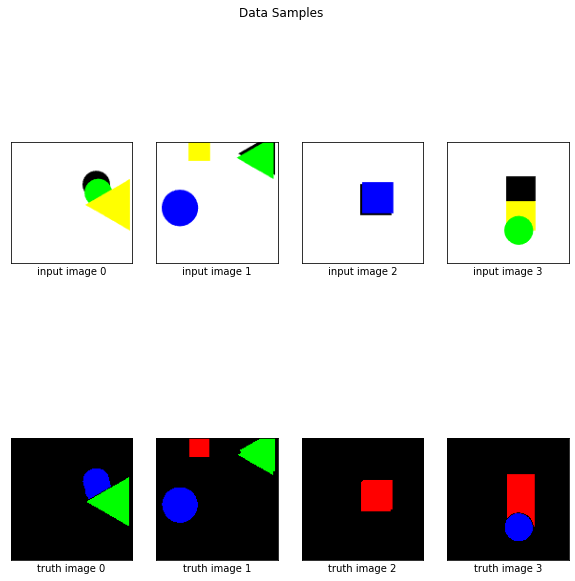

{'BATCH_SIZE': 32,
 'CLASSES': ['square', 'triangle', 'circular', 'background'],
 'DATA_AUGMENTATION': True,
 'DEBUG_MODE': True,
 'DROPOUT_PROB': 0.2,
 'GPU': 0,
 'IMAGE_CHANNEL': 3,
 'IMAGE_HEIGHT': 128,
 'IMAGE_WIDTH': 128,
 'LEARNING_RATE': 0.001,
 'LR_DECAY_FACTOR': 0.1,
 'NUM_CLASS': 4,
 'NUM_EPOCHS': 10,
 'PRINT_EVERY': 20,
 'SAVE_EVERY': 1,
 'fineGrained': False,
 'testing_data_dir': '../data/FlyingObjectDataset_10K/testing',
 'training_data_dir': '../data/FlyingObjectDataset_10K/training',
 'validation_data_dir': '../data/FlyingObjectDataset_10K/validation'}


In [746]:
if cfg.DEBUG_MODE:
    t_x, t_y = next(train_batch_generator)
    print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
    print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
    a_x, a_y = next(aug_train_batch_generator)
    print('x', a_x.shape, a_x.dtype, a_x.min(), a_x.max())
    print('y', a_y.shape, a_y.dtype, a_y.min(), a_y.max())
    plot_sample_data_with_groundtruth(a_x, a_y)
    pprint.pprint (cfg)

8) We select which processing unit to use, either CPU or GPU. In case of having multiple GPUs, we can still select which GPU to use.

In [747]:
if cfg.GPU >=0:
    print("creating network model using gpu " + str(cfg.GPU))
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cfg.GPU)
elif cfg.GPU >=-1:
    print("creating network model using cpu ")  
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

creating network model using gpu 0


9) We set the training configuration. As a part of the exercises, this function can also be updated to test different **optimization methods** such as **SGD, ADAM,** etc.

In [748]:
#opt = tf.optimizers.Adam(cfg.LEARNING_RATE)
class MyMeanIOU(tf.keras.metrics.MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)
    
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= opt, metrics=['accuracy',  MyMeanIOU(cfg.NUM_CLASS)]) 

10) We can now feed the training and validation data to the network. This will train the network for **some epochs**. Note that the epoch number is also predefined in the file called **configSegmenter.py.**

In [749]:
history = model.fit(aug_train_batch_generator,
          epochs=cfg.NUM_EPOCHS,
          verbose=1,
          steps_per_epoch=(nbr_train_data//cfg.BATCH_SIZE), # total batch number
          validation_steps=(nbr_valid_data // cfg.BATCH_SIZE), # total batch number
          validation_data=valid_batch_generator,
          callbacks=[TensorBoard(log_dir="logs/{}".format(testRun), write_graph=True, write_images=False,
                                 histogram_freq=0)])

Epoch 1/10
338/338 [==============================] - 42s 125ms/step - loss: 0.9993 - accuracy: 0.8424 - my_mean_iou_21: 0.2182 - val_loss: 0.5500 - val_accuracy: 0.8600 - val_my_mean_iou_21: 0.2150
Epoch 2/10
338/338 [==============================] - 43s 128ms/step - loss: 0.3845 - accuracy: 0.8651 - my_mean_iou_21: 0.2273 - val_loss: 0.3307 - val_accuracy: 0.8722 - val_my_mean_iou_21: 0.2629
Epoch 3/10
338/338 [==============================] - 42s 125ms/step - loss: 0.2722 - accuracy: 0.8907 - my_mean_iou_21: 0.3146 - val_loss: 0.2149 - val_accuracy: 0.9103 - val_my_mean_iou_21: 0.3612
Epoch 4/10
338/338 [==============================] - 39s 116ms/step - loss: 0.1903 - accuracy: 0.9116 - my_mean_iou_21: 0.3575 - val_loss: 0.1821 - val_accuracy: 0.9126 - val_my_mean_iou_21: 0.3702
Epoch 5/10
338/338 [==============================] - 39s 114ms/step - loss: 0.1735 - accuracy: 0.9126 - my_mean_iou_21: 0.3647 - val_loss: 0.1739 - val_accuracy: 0.9132 - val_my_mean_iou_21: 0.3756
Epoch

11) We can test the model with the test data

In [750]:
# testing model
test_result = model.evaluate(test_batch_generator,
                                       steps=(nbr_test_data//cfg.BATCH_SIZE))
test_loss = round(test_result[0], 4)
test_acc = round(test_result[1], 4)
print("Test Loss: ", str(test_loss), "Test Accuracy: ", str(test_acc))

69/69 [==============================] - 6s 83ms/step - loss: 0.1584 - accuracy: 0.9169 - my_mean_iou_21: 0.4060
Test Loss:  0.1584 Test Accuracy:  0.9169


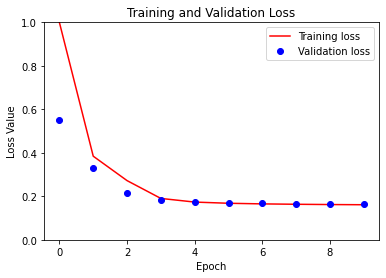

In [751]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(history.epoch))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

12) We can also show sample segmentation results

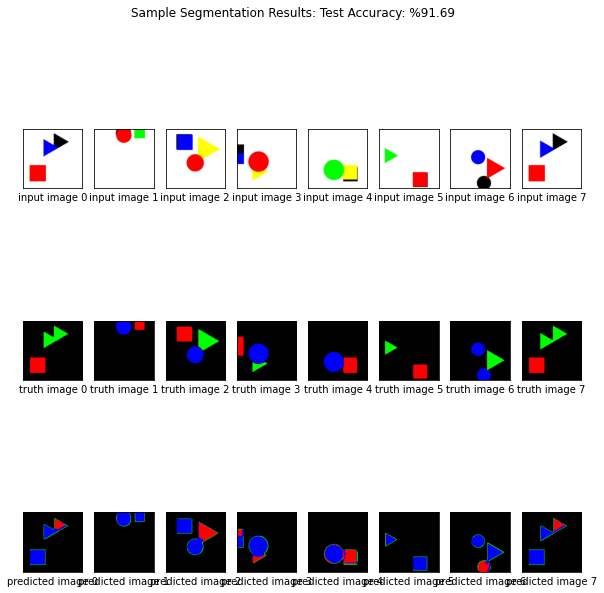

In [752]:
t_data, t_segments = next(test_batch_generator)
pred_segments = model.predict(t_data, batch_size=cfg.BATCH_SIZE)
plot_sample_segmentation_results(t_data, t_segments, pred_segments, test_acc)

13) Finally, we can save the model

In [753]:
# save the model
model.save('./logs/model_epoch_{}.h5'.format(testRun)) 

## EXERCISES

Please do all exercises desribed below. Note that all your source code as well as the log folders must be provided as final results **before May 02, 2019.** 


#### Exercise 1)
Update the network architecture given in the function **create_model** of the class SegmenterDNNModel. 

**Hint:** You can add more convolution, max pooling layers etc. Batch normalization and dropout are other options to be considered. You can also try applying different activation functions.

#### Exercise 2) 
Use different **optimization** (e.g. ADAM, SGD, etc) and **regularization** (e.g. batchnorm, dropout) methods to increase the network accuracy. Try adding more skip connections from early encoder layers to deeper decoder layers as well. 

#### Hint:
All network resposes are stored in a **log folder** which is automatically created. To visualize these responses, we can use the tensorboard as follows:
- First make sure that there is a new folder created with **a date and time stamp** under folder **logs**
- Next, open a terminal and type 
    > tensorboard --logdir=./logs
- Finally, open a web browser and type 
    > http://localhost:6006
- You can have an overview of all accuracies on the tensorboard. For more information about tensorboard, please see https://www.tensorflow.org/guide/summaries_and_tensorboard

# The report!


## Name
Fredrik Mårtensson

## Introduction
This is the third project in the course Deep learning. The project gives an deep understanding of regularization and optimization for an CNN-based **encoder-decoder architecture** to segment rgb images. Two tasks where a model will be created, updated to handle overfitting and underfitting in order to classify images into semantically meaningful regions. Results for different models is presented and their logs for future references. The models was analysed with tensorboard and compared towards each other in order to get an understanding of the presented result.
## Answers to questions
### Q1)
The first step in updating the network was to make it as simple as possible. Reduce the number of neurons and layers while achieving an okay prediction. The idea was that a simple network is easier to work on and avoids a high level of complexity. The tests were carried out in one epoch with a simpler model and no downsampling. The model gave the following result for 1) training, 2) testing. The model is not perfect and can be seen in image that the model do have some probelms of classifying the regions. However, compared to the original this model can detect the hole region and seperate it from the others compared to the original code that could only detect the edges.

1) Loss: 0.1612 - accuracy: 0.9140 - my_mean_iou_21: 0.3866 - val_loss: 0.1645 - val_accuracy: 0.9114 - val_my_mean_iou_21: 0.4003
2) Loss: 0.1584 - accuracy: 0.9169 - my_mean_iou_21: 0.4060

* down1 = Conv2D(16, (3, 3),padding='same')(inputs)
* down1 = Activation('relu')(down1)
* down2 = Conv2D(32, (3, 3), padding='same')(down1)
* down2 = Activation('relu')(down2)
* up1 = Conv2D(64, (3, 3), padding='same')(down2)
* up1 = Activation('relu')(up1)
* up2 = Conv2D(32, (3, 3), padding='same')(up1)
* up2 = Activation('relu')(up2)

![image.png](simplified.png)

### Q2)
In order to improve the model from excercise 1, several tests were performed based on the first model where test of (loss, accuracy) is presented. Something that was quite interesting is that even though a high accuracy was given the model could be really bad. Therefor a new metric, mean intersection over union (mIoU), is introduced. It was easy to get a good accuracy but the more tests that was applied showed that an accuracy less than 97% did not perform good. This could easier be showed with IoU since accuracies over 97% started to affect it and give a higher mIoU value. Multiple parameters where tested but yielded worse mIoT. The following parameters where tested; SGD, l2 regularization, different dropout/batchnormalization on differnt layers, number of layers, size of encoding/decoding layers. Most of them did not improve alone but the most effect was given by skip connection and size of each layer. 

The final model (name: 2020-12-11 14:55:20.357048) presented the following on 1) training and 2) test set: 
    
    1) loss: 0.0433 - accuracy: 0.9870 - my_mean_iou_17: 0.8840 - val_loss: 0.0615 - val_accuracy: 0.9875 - val_my_mean_iou_17: 0.8897
    2) loss: 0.0556 - accuracy: 0.9902 - my_mean_iou_17: 0.9120

This shows that the model did perform even better on the testing set than the training for the mIoU. The performance can also be observed in the graphs below.

Graphs for the best model: 

![image.png](final.png)

Truth image vs prediction:

![image.png](final_pred.png)


Lets compare the final model with any earlier model:

    * c1 = self.conv2d_block(inputs, 32, 3, batchnorm=True, dropout=True)
    * p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)
    * c2 = self.conv2d_block(p1, 64, 3, batchnorm=True, dropout=False)
    * p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)
    * c3 = self.conv2d_block(p2, 128, 3, batchnorm=True, dropout=True)
    * p3 = MaxPooling2D((2, 2), strides=(2, 2))(c3)
    * c4 = self.conv2d_block(p3, 128, 3, batchnorm=True, dropout=False)
    * p4 = MaxPooling2D((2, 2), strides=(2, 2))(c4)
    * u1 = self.upsample(p4, 256, kernel_size=3, batchnorm=True)
    * u1 = concatenate([c4, u1], axis=3)
    * u2 = self.upsample(u1, 256, kernel_size=3, batchnorm=False)
    * u2 = concatenate([c3, u2], axis=3)
    * u3 = self.upsample(u2, 256, kernel_size=3, batchnorm=True)
    * u3 = concatenate([c2, u3], axis=3)
    * u4 = self.upsample(u3, 256, kernel_size=3, batchnorm=False)
    * u4 = concatenate([c1, u4], axis=3)
    * u4 = self.conv2d_block(u4, 256, 3, batchnorm=True, dropout=False)
    * classify = Conv2D(self.num_classes, (1, 1), activation='sigmoid')(u4)

If we compare the new model (2020-12-11 14:55:20.357048) to the first model (2020-12-11 21:23:03.091269) that was given and run at 10 epochs. The model did have a hight accuracy but low mIoU which can be observed even better in the corresponding image for prediction where it could not predict a single object correct except for small details on the edges. This could imply that the network is not deep enough or missing the encoder-decoder settings.
    
    * loss: 0.1535 - accuracy: 0.9200 - my_mean_iou_20: 0.4275 - val_loss: 0.1564 - val_accuracy: 0.9184 - val_my_mean_iou_20: 0.4148
    * loss: 0.1506 - accuracy: 0.9236 - my_mean_iou_20: 0.4213

![image.png](original.png)

## Summary

The project contained a lot of exploring of different parameters. The result is within is good but at the cost of a longer training time a higher accuracy and mIoT is achieved. Since l2 did not converge it could be a possibility that the model overfit very hard. It is however hard to test since the model otherwise performs very well in terms of accuracy, loss and mIoU. mIoU was a good implementation afterwards since it resulted in a better metric that showed the true performance of model instead of an accuracy that gave high result even if the model performed poorly. The tested models can be observed in the logs and are tested between folders 1-9. Note that small changes are given in order to parametertune the network but most of them performed poorly since mIoT where not tested and accuracy did not give a good representation of reality behind the images.